<a href="https://colab.research.google.com/github/toooo-pharma/AI-/blob/main/AI%E5%89%B5%E8%96%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[06:54:11] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[06:54:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[06:54:11] Explicit valence for atom # 10 C, 5, is greater than permitted
[06:54:11] SMILES Parse Error: extra open parentheses while parsing: CC(=O)OC1=CC=CC=C1C(=OClO
[06:54:11] SMILES Parse Error: check for mistakes around position 20:
[06:54:11] CC(=O)OC1=CC=CC=C1C(=OClO
[06:54:11] ~~~~~~~~~~~~~~~~~~~~^
[06:54:11] SMILES Parse Error: Failed parsing SMILES 'CC(=O)OC1=CC=CC=C1C(=OClO' for input: 'CC(=O)OC1=CC=CC=C1C(=OClO'
[06:54:11] Explicit valence for atom # 6 Cl, 3, is greater than permitted
[06:54:11] Explicit valence for atom # 5 O, 3, is greater than permitted
[06:54:11] SMILES Parse Error: syntax error while parsing: CC(=O)OC1=CC=CC=C1=(=O)O
[06:54:11] SMILES Parse Error: check for mistakes around position 20:
[06:54:11] CC(=O)OC1=CC=CC=C1=(=O)O
[06:54:11] ~~~~~~~~~~~~~~~~~~~~^
[06:54:11] SMILES Parse Error: Failed parsing SMILES 'CC(=O)OC1=CC=

Base: インドメタシン


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

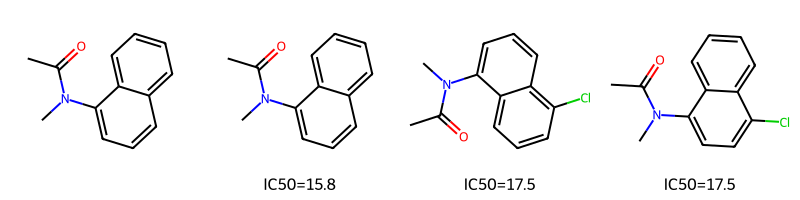

Base: アスピリン


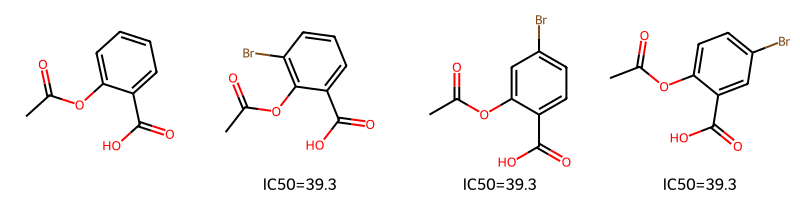

Base: ナプロキセン


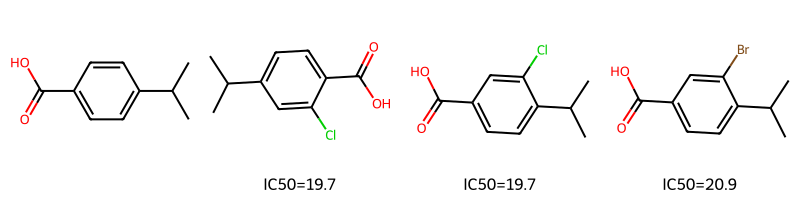

Base: ケトプロフェン


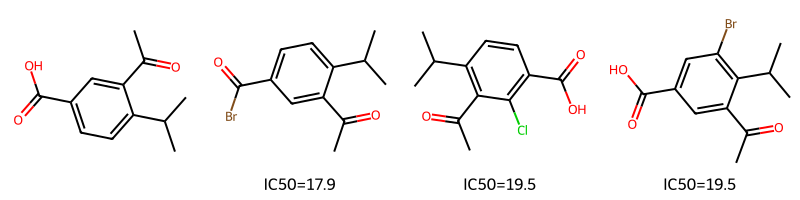

Base: イブプロフェン


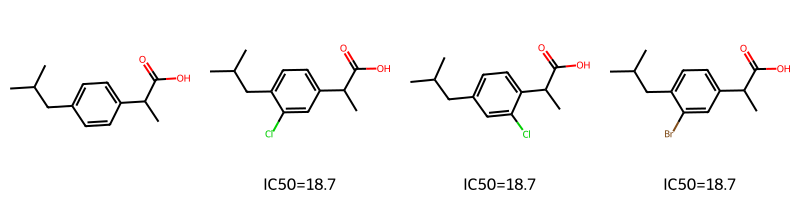

Base: メフェナム酸


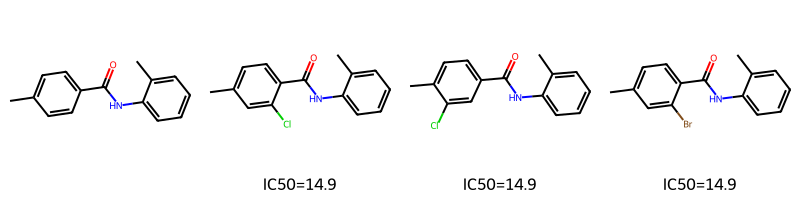

Base: ジクロフェナク


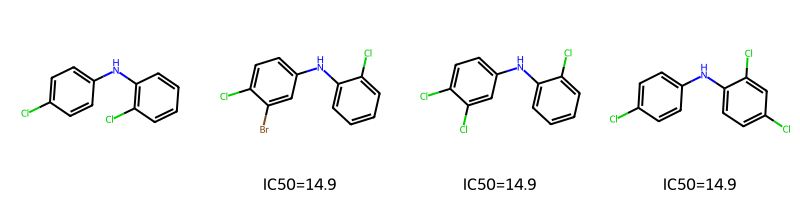

In [32]:
# --- 0. 必要ライブラリ ---
!pip install rdkit-pypi matplotlib

# --- 1. サンプルデータ作成 ---
import pandas as pd

data = {
    "Name": ["アスピリン", "イブプロフェン", "ナプロキセン", "ケトプロフェン", "インドメタシン", "ジクロフェナク", "メフェナム酸"],
    "SMILES": [
        "CC(=O)OC1=CC=CC=C1C(=O)O",       # アスピリン
        "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # イブプロフェン
        "CC(C)C1=CC=C(C=C1)C(O)=O",       # ナプロキセン
        "CC(C)C1=CC=C(C=C1C(=O)C)C(O)=O", # ケトプロフェン
        "CC(=O)N(C)C1=CC=CC2=CC=CC=C12",  # インドメタシン
        "Clc1ccc(cc1)Nc2c(Cl)cccc2",      # ジクロフェナク
        "CC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2C", # メフェナム酸
    ],
    "IC50": [80, 30, 50, 25, 10, 12, 20]
}
df = pd.DataFrame(data)

# --- 2. 分子記述子計算 ---
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors

descriptor_names = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors']
calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return list(calc.CalcDescriptors(mol))
    else:
        return [None] * len(descriptor_names)

desc = df['SMILES'].apply(smiles_to_descriptors)
desc_df = pd.DataFrame(desc.tolist(), columns=descriptor_names)
df_desc = pd.concat([df, desc_df], axis=1).dropna()

# --- 3. QSARモデル学習 ---
from sklearn.ensemble import RandomForestRegressor

X = df_desc[descriptor_names]
y = df_desc["IC50"]

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# --- 4. 分子多様化関数定義 ---
import random
from rdkit.Chem import AllChem, BRICS

def add_methyl(smiles):
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        if atom.GetDegree() < atom.GetTotalValence():
            emol = Chem.RWMol(mol)
            idx = atom.GetIdx()
            cidx = emol.AddAtom(Chem.Atom('C'))
            emol.AddBond(idx, cidx, Chem.BondType.SINGLE)
            try:
                new_mol = emol.GetMol()
                Chem.SanitizeMol(new_mol)
                return Chem.MolToSmiles(new_mol)
            except:
                continue
    return None

def add_halogen(smiles, halogen="Cl"):
    mol = Chem.MolFromSmiles(smiles)
    aromatic_carbons = [a.GetIdx() for a in mol.GetAtoms() if a.GetIsAromatic() and a.GetSymbol() == "C"]
    for idx in aromatic_carbons:
        emol = Chem.RWMol(mol)
        emol.AddAtom(Chem.Atom(halogen))
        emol.AddBond(idx, emol.GetNumAtoms()-1, Chem.BondType.SINGLE)
        try:
            new_mol = emol.GetMol()
            Chem.SanitizeMol(new_mol)
            return Chem.MolToSmiles(new_mol)
        except:
            continue
    return None

def add_hydroxy(smiles):
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == "C" and atom.GetTotalNumHs() > 0:
            emol = Chem.RWMol(mol)
            oidx = emol.AddAtom(Chem.Atom('O'))
            hidx = emol.AddAtom(Chem.Atom('H'))
            emol.AddBond(atom.GetIdx(), oidx, Chem.BondType.SINGLE)
            emol.AddBond(oidx, hidx, Chem.BondType.SINGLE)
            try:
                new_mol = emol.GetMol()
                Chem.SanitizeMol(new_mol)
                return Chem.MolToSmiles(new_mol)
            except:
                continue
    return None

def smarts_variants(smiles):
    """複数のSMARTS反応で多様な新規分子を生成"""
    mol = Chem.MolFromSmiles(smiles)
    rxn_list = [
        AllChem.ReactionFromSmarts('[cH:1]>>[c:1]Cl'), # クロロ化
        AllChem.ReactionFromSmarts('[cH:1]>>[c:1]Br'), # ブロモ化
        AllChem.ReactionFromSmarts('[C:1]>>[C:1]O'),   # 水酸化
    ]
    variants = []
    for rxn in rxn_list:
        ps = rxn.RunReactants((mol,))
        for p in ps:
            smi = Chem.MolToSmiles(p[0])
            if smi:
                variants.append(smi)
    return variants

def mutate_smiles_random(smiles):
    """SMILESをランダム一か所変異（簡易GA）"""
    chars = list(smiles)
    idx = random.randint(0, len(chars)-1)
    random_char = random.choice(['C', 'N', 'O', 'F', 'Cl', 'Br', '=', '#'])
    chars[idx] = random_char
    new_smi = ''.join(chars)
    try:
        m = Chem.MolFromSmiles(new_smi)
        if m: return Chem.MolToSmiles(m)
    except:
        return None
    return None

# --- 5. ベース分子リストと薬品名辞書 ---
base_smiles_list = data["SMILES"]
base_names = data["Name"]
base_smiles_to_name = dict(zip(base_smiles_list, base_names))

# --- 6. 多様な新規SMILES生成 ---
generated = set()
gen_info = []  # （生成元・生成法も記録）
for base in base_smiles_list:
    # 変異関数
    for func in [add_methyl, add_hydroxy, lambda s: add_halogen(s, "Cl")]:
        smi = func(base)
        if smi and Chem.MolFromSmiles(smi):
            generated.add(smi)
            gen_info.append((base, smi, func.__name__))
    # SMARTS反応（複数バリエーション）
    for smi in smarts_variants(base):
        if smi and Chem.MolFromSmiles(smi):
            generated.add(smi)
            gen_info.append((base, smi, "smarts_variant"))
    # BRICS断片再構成（各base分子→断片→10個再構成）
    mol = Chem.MolFromSmiles(base)
    if mol is not None:
        frags = list(BRICS.BRICSDecompose(mol))
        for _ in range(5):
            try:
                sel_frags = random.sample(frags, k=min(2, len(frags)))
                newmol = BRICS.BRICSBuild(sel_frags)
                for m in newmol:
                    smi = Chem.MolToSmiles(m)
                    if smi and Chem.MolFromSmiles(smi):
                        generated.add(smi)
                        gen_info.append((base, smi, "BRICS"))
            except Exception as e:
                continue
    # GA的ランダム変異（10個）
    for _ in range(10):
        smi = mutate_smiles_random(base)
        if smi and Chem.MolFromSmiles(smi):
            generated.add(smi)
            gen_info.append((base, smi, "GA_random"))

# --- 7. DataFrame化・重複排除 ---
df_gen = pd.DataFrame(gen_info, columns=["base_smiles", "generated_smiles", "method"])
df_gen = df_gen.drop_duplicates(subset=["generated_smiles"]).reset_index(drop=True)

# --- 8. QSARスクリーニング ---
results = []
for idx, row in df_gen.iterrows():
    desc = smiles_to_descriptors(row["generated_smiles"])
    if None not in desc:
        pred_ic50 = model.predict([desc])[0]
        results.append({
            "base_smiles": row["base_smiles"],
            "generated_smiles": row["generated_smiles"],
            "method": row["method"],
            "Predicted_IC50": pred_ic50
        })
df_screen = pd.DataFrame(results)
df_screen = df_screen.sort_values("Predicted_IC50").reset_index(drop=True)

# --- 9. 各base_smilesごとにTop3抽出＆可視化 ---
from rdkit.Chem import Draw

top3_list = []
for base, group in df_screen.groupby("base_smiles"):
    topn = group.nsmallest(3, "Predicted_IC50")
    for _, row in topn.iterrows():
        top3_list.append({
            "base_smiles": base,
            "generated_smiles": row["generated_smiles"],
            "Predicted_IC50": row["Predicted_IC50"]
        })
df_top3 = pd.DataFrame(top3_list)

for base in df_top3["base_smiles"].unique():
    base_mol = Chem.MolFromSmiles(base)
    subset = df_top3[df_top3["base_smiles"] == base]
    mutant_mols = [Chem.MolFromSmiles(s) for s in subset["generated_smiles"]]
    mols = [base_mol] + mutant_mols
    base_label = base_smiles_to_name.get(base, "Base")
    legends = [base_label] + [f"IC50={ic50:.1f}" for ic50 in subset["Predicted_IC50"]]
    print(f"Base: {base_label}")
    img = Draw.MolsToGridImage(
        mols, legends=legends, molsPerRow=4, subImgSize=(200, 200)
    )
    display(img)